# **Part 7: Regression model: Factors affecting the Claim Payment Amount**

## **I. Dataset Overview and Variable Selection Rationale:**
### 1. Dataset Compilation

The final dataset used in this regression analysis was constructed by merging multiple sheets from the insurance claims system. The following sheets were joined using relevant keys (e.g., `CoverID`, `InsuredID`, `Product ID`):

- `Coverages`
- `Claim Announcements`
- `Claim Payments`
- `Claim Reserves`
- `Participants`

After merging, the dataset was refined to include key variables relevant to the analysis of insurance claim amounts. The selected columns are:

- `PaymentAmount` (Dependent Variable)
- `CoverID`, `InsuredID` (Identifiers, later dropped for modeling)
- `MaritalStatus`, `Gender`
- `Product ID`, `ProductCategory`
- `Policy States`, `AnnualizedPolicyPremium`
- `LastForecastAmount`, `ProvisionAmount`
- `ClosingDate`, `AnnouncementDate`, `Birthdate` (used for derived variables)

In addition to the existing columns, two new variables were derived:

- **`ProcessingTime`**: Calculated as the difference between `ClosingDate` and `AnnouncementDate`, this variable represents how long it took for the claim to be processed.
- **`Age`**: Calculated as the difference between the current year (2025) and the insured individual's `Birthdate`.

These transformations yielded a clean and enriched dataset suitable for regression analysis.

---

### 2. Variable Selection Rationale

The goal of this study is to identify key drivers of **`PaymentAmount`**, the amount paid out on insurance claims. Below is the reasoning for selecting each independent variable:

| Variable                  | Description                                                                 | Rationale                                                                                  |
|---------------------------|-----------------------------------------------------------------------------|--------------------------------------------------------------------------------------------|
| `MaritalStatus`           | Marital status of the insured                                               | May affect risk profile and type of product chosen                                         |
| `Gender`                  | Gender of the insured                                                       | Potential behavioral differences in claiming or policy type                                |
| `Product ID`              | Internal identifier of the insurance product                                | Allows segmentation by specific product offerings                                          |
| `Policy States`           | Status of the policy (e.g., Active, Cancelled)                              | Reflects the operational state of the policy at claim time                                 |
| `AnnualizedPolicyPremium` | Total yearly premium paid for the policy                                    | Reflects the scale/value of the policy; may correlate with payout size                    |
| `ProductCategory`         | Broader classification of the product (e.g., Life, Hospitalisation Riders) | Different product categories have structurally different payout levels                    |
| `LastForecastAmount`      | Last forecasted payout prior to claim settlement                            | A proxy for expected loss – useful in predicting actual payment                            |
| `ProvisionAmount`         | Reserve amount allocated for the claim                                      | Reflects anticipated financial commitment – likely predictive of final payment             |
| `ProcessingTime`          | Number of days between claim announcement and claim closing                 | Measures claim processing duration; may influence payout due to penalties or negotiations |
| `Age`                     | Age of the insured person                                                   | A demographic risk factor; may influence coverage amount and product eligibility           |

---

- **`PaymentAmount`**: The monetary value of the actual insurance claim payment made to the insured. This is the key outcome the model seeks to predict and understand.

This careful selection and derivation of variables ensure the model includes both demographic, policy, and operational dimensions, allowing for a well-rounded regression analysis of claim payments.


## **II. Multiple regression model**

### 1. Multiple regression by using Scikit Learn

In [94]:
# Import necessary libraries
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import numpy as np

# Load the dataset
file_path = "C:/Users/ADMIN88/Documents/Big data analysis/Data/Reg.xlsx"
df = pd.read_excel(file_path, sheet_name='Sheet1', engine='openpyxl')

# Display the first few rows
print(df.head())

   PaymentAmount  CoverID  InsuredID MaritalStatus Gender   Age  Product ID  \
0         342.00      160     375479       Married   MALE  38.0          58   
1       17896.97      402    2004402       Married   MALE  58.0          58   
2        1582.00      402    2004402       Married   MALE  58.0          58   
3         655.00      402    2004402       Married   MALE  58.0          58   
4         406.00      402    2004402       Married   MALE  58.0          58   

  Policy States  AnnualizedPolicyPremium         ProductCategory  \
0        Active                   880.73  Hospitalisation riders   
1        Active                  1209.78  Hospitalisation riders   
2        Active                  1209.78  Hospitalisation riders   
3        Active                  1209.78  Hospitalisation riders   
4        Active                  1209.78  Hospitalisation riders   

   LastForecastAmount  ProvisionAmount  ProcessingTime  
0              307.06          1941.14           29171  
1 

##### Data processing: Handling with missing values and convert categorical varible to dummy variables

In [95]:
# Drop identifier columns that are not useful for regression
df = df.drop(columns=["CoverID", "InsuredID", "Product ID"])

# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Check for missing values
df.isnull().sum()

# Handle missing values using SimpleImputer
num_imputer = SimpleImputer(strategy="mean")
df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])

cat_imputer = SimpleImputer(strategy="most_frequent")
df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

# Convert categorical variables to dummy variables
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Ensure all data is numeric
df = df.apply(pd.to_numeric, errors='coerce')

In [96]:
# Describe the dataset to understand its structure and summary statistics
print("Dataset description:")
df.describe(include='all')

Dataset description:


,PaymentAmount,Age,AnnualizedPolicyPremium,LastForecastAmount,ProvisionAmount,ProcessingTime,MaritalStatus_Married,MaritalStatus_Single,Gender_MALE,Policy States_Cancelled,ProductCategory_Hospitalisation riders,ProductCategory_Life Consumer,ProductCategory_Non hospitalisation riders
count,28238.000000,28238.000000,28238.000000,28238.000000,28238.000000,28238.000000,28238,28238,28238,28238,28238,28238,28238
unique,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,2,2,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,True,False,True,False,True,False,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,15859,19066,15200,24368,27237,28221,27360
mean,1203.197446,41.625239,1173.210648,6105.023476,3569.210924,4716.978044,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,3966.077647,19.265567,938.789267,13385.075313,5408.876526,10624.587352,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-60000.000000,6.000000,9.590000,1.970000,1.970000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,188.000000,25.000000,510.930000,1090.200000,1303.950000,99.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,500.000000,46.000000,909.790000,2609.100000,2625.000000,163.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,1342.875000,56.000000,1554.300000,5461.740000,4200.000000,276.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Build and Evaluate the OLS Regression Model
- Variable Definition:
   - The dependent variable (`y`) is set to `PaymentAmount`, which represents the value to be predicted.
   - The independent variables (`X`) include all other columns in the dataset, excluding `PaymentAmount`.

- Add Constant:
   - A constant term is added to the independent variables to account for the intercept in the regression equation using `sm.add_constant(X)`.

- Handling Missing Values:
   - Any remaining missing values in both `X` and `y` are filled with zero to ensure model compatibility.

- Type Conversion:
   - All data are explicitly converted to `float64` to avoid any datatype issues during model fitting.

- Train-Test Split:
   - The dataset is split into training and testing sets using `train_test_split()` from `scikit-learn`.
   - 80% of the data is used for training, and 20% is reserved for testing.
   - A fixed `random_state=42` ensures reproducibility.

- Model Training:
   - An OLS regression model is trained on the **training set** (`X_train`, `y_train`) using `statsmodels.OLS()`.
   - The `.fit()` function is used to estimate the model coefficients.

- Model Summary:
   - The model’s statistical summary is printed using `.summary()`, which provides key metrics like R-squared, coefficients, t-values, and p-values.

In [97]:
# Define dependent and independent variables
y = df['PaymentAmount']
X = df.drop(columns=['PaymentAmount'])

# Add constant for regression model
X = sm.add_constant(X)

# Fill any remaining NaN values with 0 (if needed)
X = X.fillna(0)
y = y.fillna(0)

# Ensure data types are correct before splitting
X = X.astype('float64')
y = y.astype('float64')

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the regression model
model = sm.OLS(y_train, X_train).fit()

# Print summary of the model
print(model.summary())

# Debugging step: Print column data types to confirm all are numeric
print(X.dtypes)

                            OLS Regression Results                            
Dep. Variable:          PaymentAmount   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     249.2
Date:                Tue, 15 Apr 2025   Prob (F-statistic):               0.00
Time:                        23:52:35   Log-Likelihood:            -2.1883e+05
No. Observations:               22590   AIC:                         4.377e+05
Df Residuals:                   22577   BIC:                         4.378e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

##### Regression Results Interpretation and Suggestions

##### 1. Model Overview

The **Ordinary Least Squares (OLS)** regression was conducted to understand the influence of multiple policyholder and claim-related factors on the dependent variable, **`PaymentAmount`**.

- **R-squared** = 0.117
- **Adjusted R-squared** = 0.117  
  ➤ This indicates that **approximately 11.7%** of the variability in the payment amount is explained by the model. While this is a relatively low explanatory power, it is not uncommon in real-world financial or insurance data where many unobserved factors affect the outcome.

- **F-statistic** = 249.2, **p-value = 0.000**  
  ➤ The overall model is statistically significant, meaning at least one of the independent variables has a significant relationship with the payment amount.

---

##### 2. Key Findings

| Variable | Coefficient | p-value | Interpretation |
|---------|-------------|---------|----------------|
| `Age` | +11.07 | **0.000** | Statistically significant. Older individuals tend to receive slightly higher payments, possibly due to higher risk profiles. |
| `AnnualizedPolicyPremium` | -0.0063 | 0.859 | Not significant. Premium level does not show a clear impact on claim payments. |
| `LastForecastAmount` | +0.0109 | **0.000** | Significant. Higher forecasted amounts are positively associated with the final payment. |
| `ProvisionAmount` | +0.0255 | **0.000** | Significant. A higher provision is predictive of a higher actual payment. |
| `ProcessingTime` | +0.0003 | 0.907 | Not significant. No meaningful effect on payment amount. |
| `MaritalStatus_Single` | -183.20 | **0.041** | Marginally significant. Single individuals tend to receive slightly lower payments compared to the base category. |
| `Gender_MALE` | +29.41 | 0.576 | Not significant. Gender does not affect the payment in this dataset. |
| `Policy States_Cancelled` | +44.36 | 0.566 | Not significant. Policy state (cancelled) is not associated with significantly different payments. |
| `ProductCategory_Life Consumer` | +50,490 | **0.000** | Strong and significant. Life insurance claims are much larger in magnitude. |
| `ProductCategory_Hospitalisation riders` | -4549.42 | **0.000** | Strong negative effect. This category is associated with lower claim payments. |
| `ProductCategory_Non hospitalisation riders` | -5060.16 | **0.000** | Also associated with significantly lower payments. |

##### Interpretation Highlights:
- **Main drivers** of PaymentAmount include:
  - **Product Category** (Life Consumer +, Rider -)
  - **Age**, **ProvisionAmount**, and **LastForecastAmount**
- **Insignificant predictors**:
  - **AnnualizedPolicyPremium**
  - **ProcessingTime**
  - **Gender**
  - **Policy Status**

---

##### Suggestions for Model Improvement

- **Feature Engineering**:
   - Include interaction terms or non-linear transformations (e.g., log of `AnnualizedPolicyPremium`, squared `Age`) to capture more complex relationships.
   - Create additional categorical groupings for product types or segmentations by policy size.

- **Multicollinearity Check**:
   - The condition number (7.92e+05) is quite high, suggesting possible multicollinearity. Consider using **Variance Inflation Factor (VIF)** to assess and possibly remove collinear variables.

## 2. Multiple regression using interaction terms

##### Adding Interaction Terms to Improve Model Performance:
To enhance the **explanatory power** of the regression model and **increase the R-squared**, we introduced several **interaction terms**. Interaction terms allow us to capture **non-additive effects** between variables—scenarios where the influence of one predictor depends on the level of another. In real-world insurance data, such relationships are common, especially between demographic characteristics and policy features.

The following interactions were included in the updated model:

- **`Age × AnnualizedPolicyPremium`**: to examine whether the impact of premium size varies across different age groups.
- **`LastForecastAmount × ProvisionAmount`**: to capture how combined expectations and provisions influence final payments.
- **`ProductCategory_Life_Consumer × Gender_MALE`**: to detect whether gender differences affect payment specifically within life insurance products.
- **`MaritalStatus_Married × Policy_States_Cancelled`**: to explore whether the effect of policy cancellation is moderated by marital status.



In [98]:
from patsy import dmatrices
# Rename columns to remove spaces
df.columns = df.columns.str.replace(" ", "_")

# Now, define your formula using the updated column names
formula = """PaymentAmount ~ Age + AnnualizedPolicyPremium + LastForecastAmount + ProvisionAmount 
             + MaritalStatus_Married + MaritalStatus_Single + Gender_MALE + Policy_States_Cancelled 
             + ProcessingTime + ProductCategory_Hospitalisation_riders + ProductCategory_Life_Consumer + ProductCategory_Non_hospitalisation_riders
             + Age:AnnualizedPolicyPremium + LastForecastAmount:ProvisionAmount + ProductCategory_Life_Consumer:Gender_MALE
             + MaritalStatus_Married:Policy_States_Cancelled"""

# Generate design matrices
y, X = dmatrices(formula, data=df, return_type="dataframe")

# Fit OLS model
model = sm.OLS(y, X).fit()

# Print summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          PaymentAmount   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     1158.
Date:                Tue, 15 Apr 2025   Prob (F-statistic):               0.00
Time:                        23:52:49   Log-Likelihood:            -2.6691e+05
No. Observations:               28238   AIC:                         5.339e+05
Df Residuals:                   28221   BIC:                         5.340e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

##### Regression Results Interpretation

##### 1. Model Overview

The **Ordinary Least Squares (OLS)** regression with interactions terms was conducted to understand the influence of multiple policyholder and claim-related factors on the dependent variable, **`PaymentAmount`**.

- **R-squared** = 0.396
- **Adjusted R-squared** = 0.39.6  
  ➤ This indicates that **approximately 39.6%** of the variability in the payment amount is explained by the model. 

- **F-statistic** = 1158, **p-value = 0.000**  
  ➤ The overall model is statistically significant, meaning at least one of the independent variables has a significant relationship with the payment amount.

Compared to the previous base model which had an **R-squared of 0.117**, the updated regression model with interaction terms shows a **substantial improvement**, achieving an **R-squared of 0.396**. This means the model now explains approximately **39.6% of the variance** in `PaymentAmount`, indicating that the interaction terms have significantly increased the model’s **explanatory power**. Additionally, the **F-statistic remains highly significant**, confirming that the model as a whole fits the data better.

---

##### 2.Key Findings

- **Demographic and Policy Factors**:
  - `Age`, `Gender_MALE`, and `Policy_States_Cancelled` are significant predictors of `PaymentAmount`.
  - `Gender_MALE` has a **positive coefficient**, suggesting males receive slightly higher payments, holding other variables constant.
  - `Policy_States_Cancelled` is **negatively associated** with payment, implying cancelled policies lead to lower payouts.

- **Product Category Effects**:
  - `ProductCategory_Life_Consumer` has a **very large positive effect**, indicating it contributes the most to claim payments.
  - `ProductCategory_Hospitalisation_riders` and `ProductCategory_Non_hospitalisation_riders` are associated with **lower claim amounts**.

- **Interaction Effects**:
  - `ProductCategory_Life_Consumer × Gender_MALE` is **strongly negative**, showing that **male customers in this category receive lower payments** than females.
  - `MaritalStatus_Married × Policy_States_Cancelled` is **positive and significant**, suggesting married individuals with cancelled policies receive **higher payments**.
  - `LastForecastAmount × ProvisionAmount` shows a **small but significant positive effect**, indicating combined forecasts and provisions influence payouts.

- **Insignificant Predictors**:
  - `AnnualizedPolicyPremium` and its interaction with `Age` are **not statistically significant**, suggesting limited predictive value.
  - Marital status variables alone (`MaritalStatus_Married` and `Single`) were also **not significant** independently.



## III. Visualization

### 1. Correlation matrix

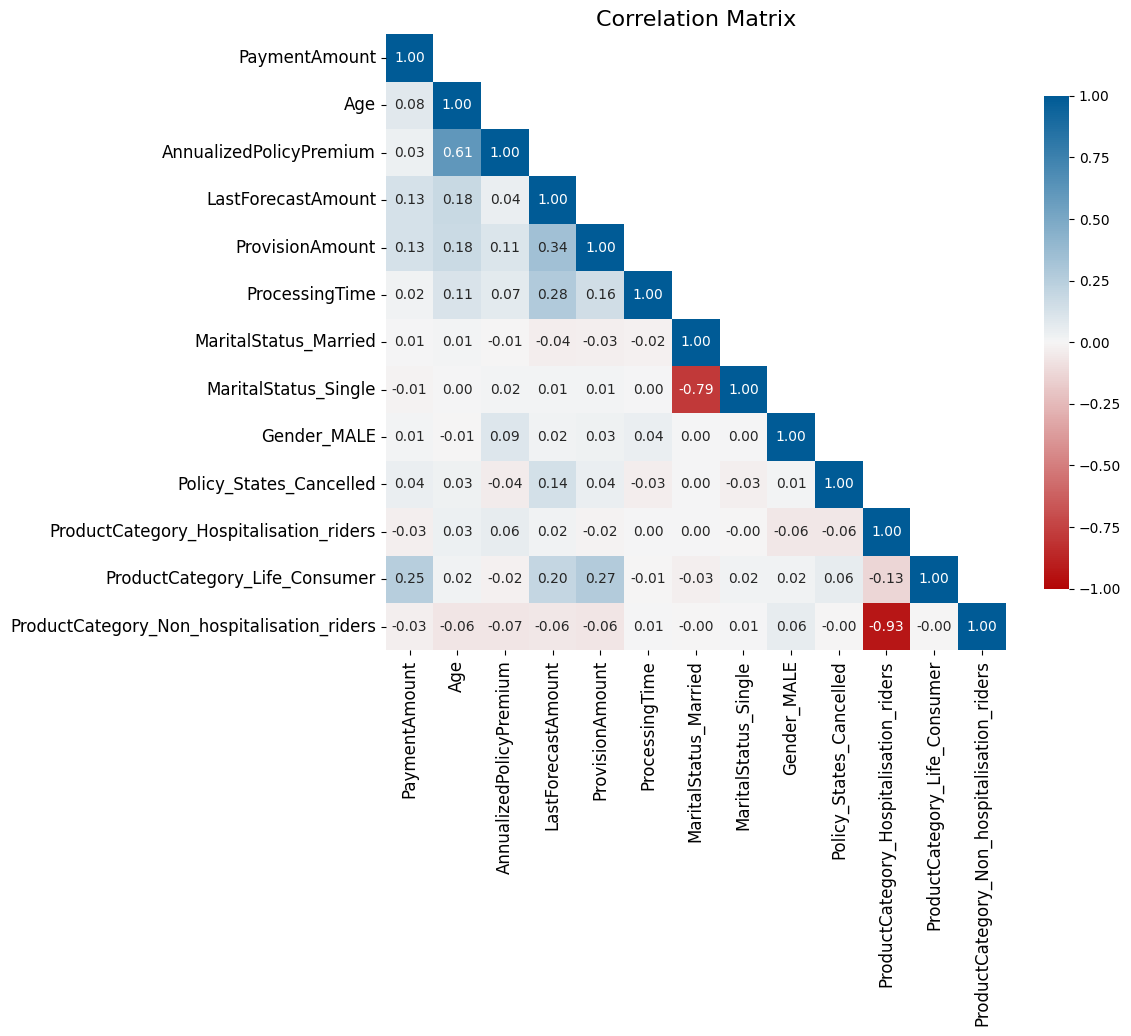

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

custom_cmap = LinearSegmentedColormap.from_list(
    "custom_theme", ["#b30707", "#f5f5f5", "#005b96"]  
)

# Compute the correlation matrix
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)  # 'k=1' excludes the diagonal

# Plot the correlation matrix with the lower triangle and diagonal 
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    mask=mask,  
    annot=True,
    fmt=".2f",
    cmap=custom_cmap,  
    cbar_kws={"shrink": 0.8},  
    vmin=-1, vmax=1  
)
plt.title("Correlation Matrix", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

##### Correlation Matrix Analysis

- **Target Variable (`PaymentAmount`)**:
  - Shows **weak to moderate positive correlation** with:
    - `LastForecastAmount` (0.13)
    - `ProvisionAmount` (0.13)
    - `Age` (0.08)
    - `ProductCategory_Life_Consumer` (0.25) — the strongest among all features.
  - These suggest that higher forecasts, provisions, age, and being part of the Life Consumer product category are loosely associated with higher claim payments.

- **Strong Correlations Among Predictors**:
  - `MaritalStatus_Married` and `MaritalStatus_Single`: **strong negative correlation (-0.79)**, expected due to their mutual exclusivity.
  - `ProductCategory_Hospitalisation_riders` and `ProductCategory_Non_hospitalisation_riders`: **very strong negative correlation (-0.93)**, indicating multicollinearity due to dummy encoding of mutually exclusive categories.
  - `ProductCategory_Life_Consumer` and the other two product types also show **strong negative relationships** (around -0.93 and -0.13), confirming they are distinct product types.

- **Mild Positive Correlations**:
  - Between `Age` and `AnnualizedPolicyPremium` (0.61), suggesting that older customers tend to have higher annualized premiums.
  - `LastForecastAmount` is positively correlated with both `ProvisionAmount` (0.34) and `ProcessingTime` (0.28), implying that larger forecasts are associated with longer processing and larger provisions.


#### 2. Boxplots of Payment Amounts Distribution

C:\Users\ADMIN88\AppData\Local\Temp\ipykernel_11648\189927729.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['AgeGroup'] = pd.qcut(df_filtered['Age'], q=4,
C:\Users\ADMIN88\AppData\Local\Temp\ipykernel_11648\189927729.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['ForecastGroup'] = pd.cut(df_filtered['LastForecastAmount'],
C:\Users\ADMIN88\AppData\Local\Temp\ipykernel_11648\189927729.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

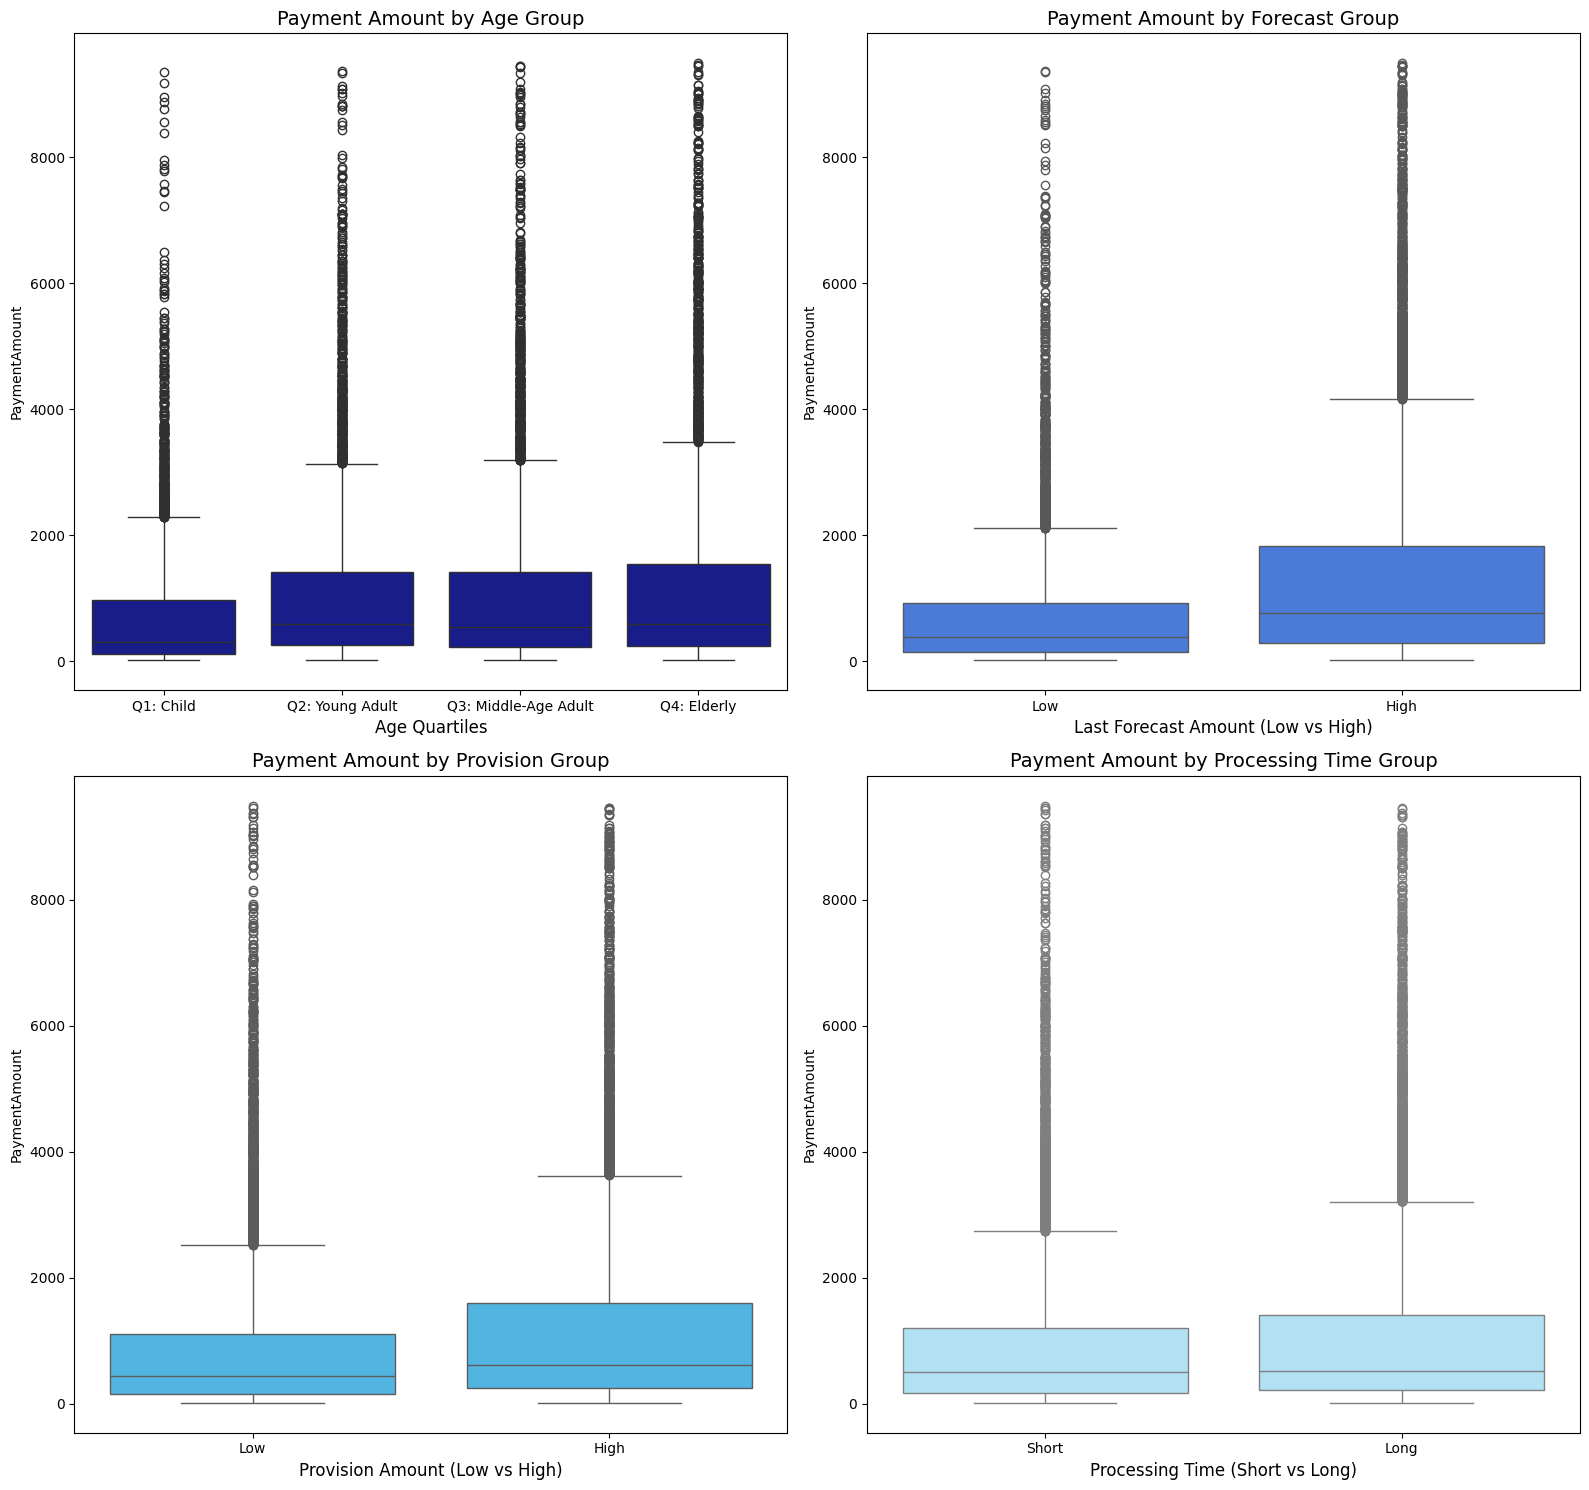

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter DataFrame without extreme outliers in PaymentAmount
df_filtered = df[(df['PaymentAmount'] > df['PaymentAmount'].quantile(0.01)) &
                 (df['PaymentAmount'] < df['PaymentAmount'].quantile(0.99))]

# Create Age quartiles
df_filtered['AgeGroup'] = pd.qcut(df_filtered['Age'], q=4,
                                  labels=['Q1: Child', 'Q2: Young Adult', 'Q3: Middle-Age Adult', 'Q4: Elderly'])

# Create binary groups for continuous variables
df_filtered['ForecastGroup'] = pd.cut(df_filtered['LastForecastAmount'],
                                      bins=[-float('inf'), df_filtered['LastForecastAmount'].median(), float('inf')],
                                      labels=['Low', 'High'])
df_filtered['ProvisionGroup'] = pd.cut(df_filtered['ProvisionAmount'],
                                       bins=[-float('inf'), df_filtered['ProvisionAmount'].median(), float('inf')],
                                       labels=['Low', 'High'])
df_filtered['ProcessingGroup'] = pd.cut(df_filtered['ProcessingTime'],
                                        bins=[-float('inf'), df_filtered['ProcessingTime'].median(), float('inf')],
                                        labels=['Short', 'Long'])

# Set up subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 15))

# Boxplot 1: Age Group
sns.boxplot(x='AgeGroup', y='PaymentAmount', data=df_filtered, ax=axes[0, 0], color='#050C9C')
axes[0, 0].set_title('Payment Amount by Age Group', fontsize=14)
axes[0, 0].set_xlabel('Age Quartiles', fontsize=12)

# Boxplot 2: Forecast Group
sns.boxplot(x='ForecastGroup', y='PaymentAmount', data=df_filtered, ax=axes[0, 1], color='#3572EF')
axes[0, 1].set_title('Payment Amount by Forecast Group', fontsize=14)
axes[0, 1].set_xlabel('Last Forecast Amount (Low vs High)', fontsize=12)

# Boxplot 3: Provision Group
sns.boxplot(x='ProvisionGroup', y='PaymentAmount', data=df_filtered, ax=axes[1, 0], color='#3ABEF9')
axes[1, 0].set_title('Payment Amount by Provision Group', fontsize=14)
axes[1, 0].set_xlabel('Provision Amount (Low vs High)', fontsize=12)

# Boxplot 4: Processing Time Group
sns.boxplot(x='ProcessingGroup', y='PaymentAmount', data=df_filtered, ax=axes[1, 1], color='#A7E6FF')
axes[1, 1].set_title('Payment Amount by Processing Time Group', fontsize=14)
axes[1, 1].set_xlabel('Processing Time (Short vs Long)', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()

##### Boxplot Analysis: Payment Amount by Key Groups

- **Age Group**:
  - Payment amounts appear to slightly increase with age, particularly in the `Q3: Middle-age adult` and `Q4: Elderly` groups. The distribution is heavily right-skewed across all age groups. Suggests that older policyholders tend to receive higher claim payments.
  - This aligns with the regression output where `Age` was **positively and significantly associated** with `PaymentAmount` (`coef = 10.84`, `p < 0.001`).

- **Forecast Group (Low vs High)**:
  - The `High` forecast group shows a noticeably wider spread and higher outliers in claim payments. The median is also higher in the `High` forecast category. Indicates that forecast estimates are informative predictors of actual claim sizes.
  - This supports the positive and significant relationship from the regression (`LastForecastAmount` and its interaction term were both highly significant, `p < 0.001`).

- **Provision Amount Group (Low vs High)**:
  - Higher provision groups tend to have higher and more dispersed claim payments. Payment distribution shows greater variance compared to the `Low` group. Suggests that provision levels set aside by insurers are indicative of final claim outcomes.
  - Again, this complements the regression where `ProvisionAmount` had a **positive and significant effect** on payments (`coef = 0.0366`, `p < 0.001`).

- **Processing Time (Short vs Long)**:
  - Claims with longer processing times tend to have slightly higher payment values. Both `Short` and `Long` processing times display similar medians, but the `Long` group has a slightly broader range. Imply that longer processing times are associated with **smaller adjusted payments**, potentially due to claim complexity or administrative delay.
  - Interestingly, in the regression model, `ProcessingTime` had a **negative coefficient** (`-0.0084`, `p < 0.001`), suggesting that after controlling for other factors, longer processing times are **associated with lower payments**, possibly due to complex claims being scrutinized more heavily.

#### 3. Interaction Effect: Product Category × Gender on Payment Amount

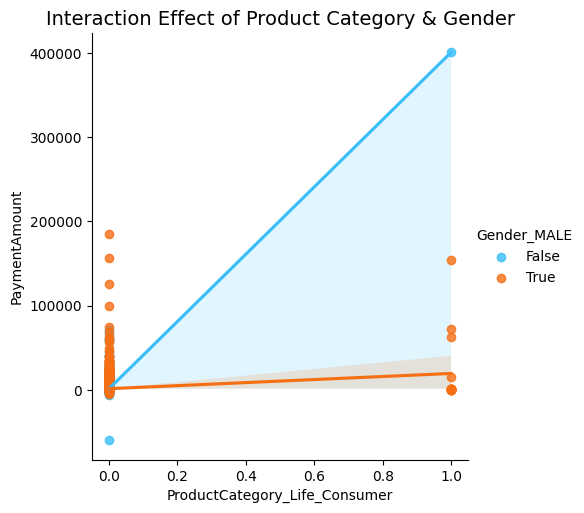

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a custom color palette for Gender_MALE
custom_palette = {True: '#f76f14', False: '#3ABEF9'}

# Create the lmplot with the specified palette
sns.lmplot(x='ProductCategory_Life_Consumer', y='PaymentAmount',
           hue='Gender_MALE', data=df, palette=custom_palette)

# Add a title
plt.title("Interaction Effect of Product Category & Gender", fontsize=14)

# Show the plot
plt.show()

##### Interaction Effect Plot Analysis

The plot above visualizes the **interaction effect between Product Category (`Life_Consumer`) and Gender** on `PaymentAmount`. The x-axis represents whether the product category is "Life Consumer" (`1`) or not (`0`), and the y-axis shows the corresponding payment amounts. Separate regression lines are drawn for **male** and **female**.

- **For Female (`Gender_MALE = False`)**:
  - There is a strong positive relationship between being in the `Life_Consumer` product category and receiving a higher payment amount.
  - The slope of the blue line (female) increases steeply, indicating that females with `Life_Consumer` products are more likely to receive significantly higher claim payments.

- **For Male (`Gender_MALE = True`)**:
  - The orange line representing males also shows a positive trend, but with a **much flatter slope** compared to females.
  - This suggests that for males, switching to the `Life_Consumer` category **does not lead to as steep an increase** in payment amount.

- This interaction pattern is supported by the regression result:
  - The interaction term **`Gender_MALE * ProductCategory_Life_Consumer`** had a **significantly negative coefficient** (`coef = -263.39`, `p < 0.001`), suggesting that the positive impact of `Life_Consumer` products on claim payments is **diminished for male customers**.
  - In contrast, **`ProductCategory_Life_Consumer`** by itself had a **strong positive coefficient** (`coef = 362.82`, `p < 0.001`), confirming the large increase in payment for this product category, especially among **female customers**.

➤ This interaction effect implies that **female benefit more** from `Life_Consumer` product plans in terms of claim payment amount, while **male see a relatively modest gain**. This may reflect differences in product design, claim behavior between genders.
